In [1]:
import quandl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import pandas_datareader.data as web
from datetime import date
import scipy

In [2]:
quandl.ApiConfig.api_key = "CTnhpzRXRtpR9w1bU7ae"

ue_rate = quandl.get("FRED/UNRATE", start_date="2000-12-01")
job_vacancies = quandl.get("FRED/JTSJOR", start_date="2000-12-01")

In [3]:
report_start = date.fromisoformat("2000-12-01")
report_end = date.today()
data = web.get_data_fred(["UNRATE", "JTSJOR"], report_start, report_end)

data["UNRATE"] = data["UNRATE"].apply(lambda x: x / 100)
data["JTSJOR"] = data["JTSJOR"].apply(lambda x: x / 100)

pd.options.display.float_format = lambda x: (
    "{:.1%}".format(x) if x < 100 else "{:.0f}".format(x)
)
data.loc["2001":]

,UNRATE,JTSJOR
DATE,,
2001-01-01,4.2%,3.8%
2001-02-01,4.2%,3.7%
2001-03-01,4.3%,3.5%
2001-04-01,4.4%,3.4%
2001-05-01,4.3%,3.2%
...,...,...
2024-03-01,3.8%,5.0%
2024-04-01,3.9%,4.8%
2024-05-01,4.0%,4.9%


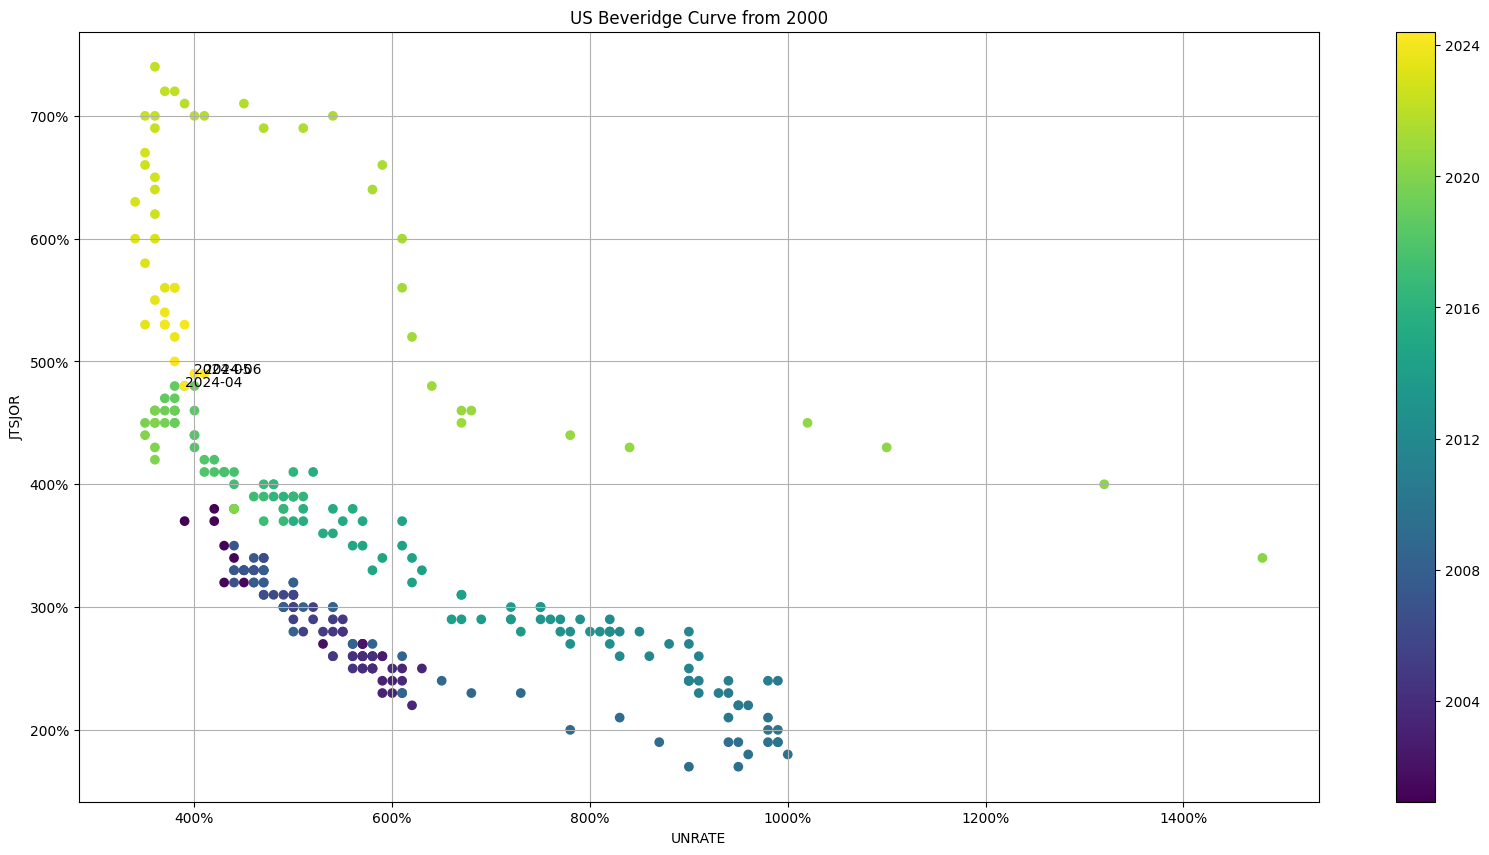

In [4]:
report_start = date.fromisoformat("2000-12-01")
report_end = date.today()
data = web.get_data_fred(['UNRATE', 'JTSJOR'], report_start, report_end)

bvg_curve_df = data.iloc[:, [0, 1]].dropna()
fig, ax = plt.subplots(figsize=(20, 10))
sc = ax.scatter(
    x=bvg_curve_df.iloc[:, 0],
    y=bvg_curve_df.iloc[:, 1],
    c=mdates.date2num(bvg_curve_df.index),
)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_xlabel(bvg_curve_df.columns[0])
ax.set_ylabel(bvg_curve_df.columns[1])
ax.set_title("US Beveridge Curve from {:%Y}".format(bvg_curve_df.index[0]))

# Add labels to the last three months for ease of understanding the current trend
for i in range(-1, -4, -1):
    plt.text(
        bvg_curve_df.iloc[i, 0],
        bvg_curve_df.iloc[i, 1],
        f"{bvg_curve_df.index[i]:%Y-%m}",
    )
ax.grid(True)
loc = mdates.AutoDateLocator()
_ = fig.colorbar(sc, ticks=loc, format=mdates.AutoDateFormatter(loc))

In [5]:
pct_change_core_cpi = (
    web.get_data_fred("CPILFESL", start=report_start, end=report_end)
    .pct_change(12)
    .dropna()
)
phillips_curve_df = pd.concat([data.iloc[:, 0], pct_change_core_cpi], axis=1).dropna()
phillips_curve_df.rename(columns={"CPILFEESI": "Core Inflation"}, inplace=True)

In [6]:
decades = [
    (date(2000, 1, 1), date(2009, 12, 31)),
    (date(2010, 1, 1), date(2019, 12, 31)),
    (date(2020, 1, 1), date.today()),
]

cols = phillips_curve_df.columns
slopes_and_intercepts = [
    scipy.stats.linregress(
        phillips_curve_df.loc[dcd[0] : dcd[1], cols[0]],
        phillips_curve_df.loc[dcd[0] : dcd[1], cols[1]],
    )[0:2]
    for dcd in decades
]

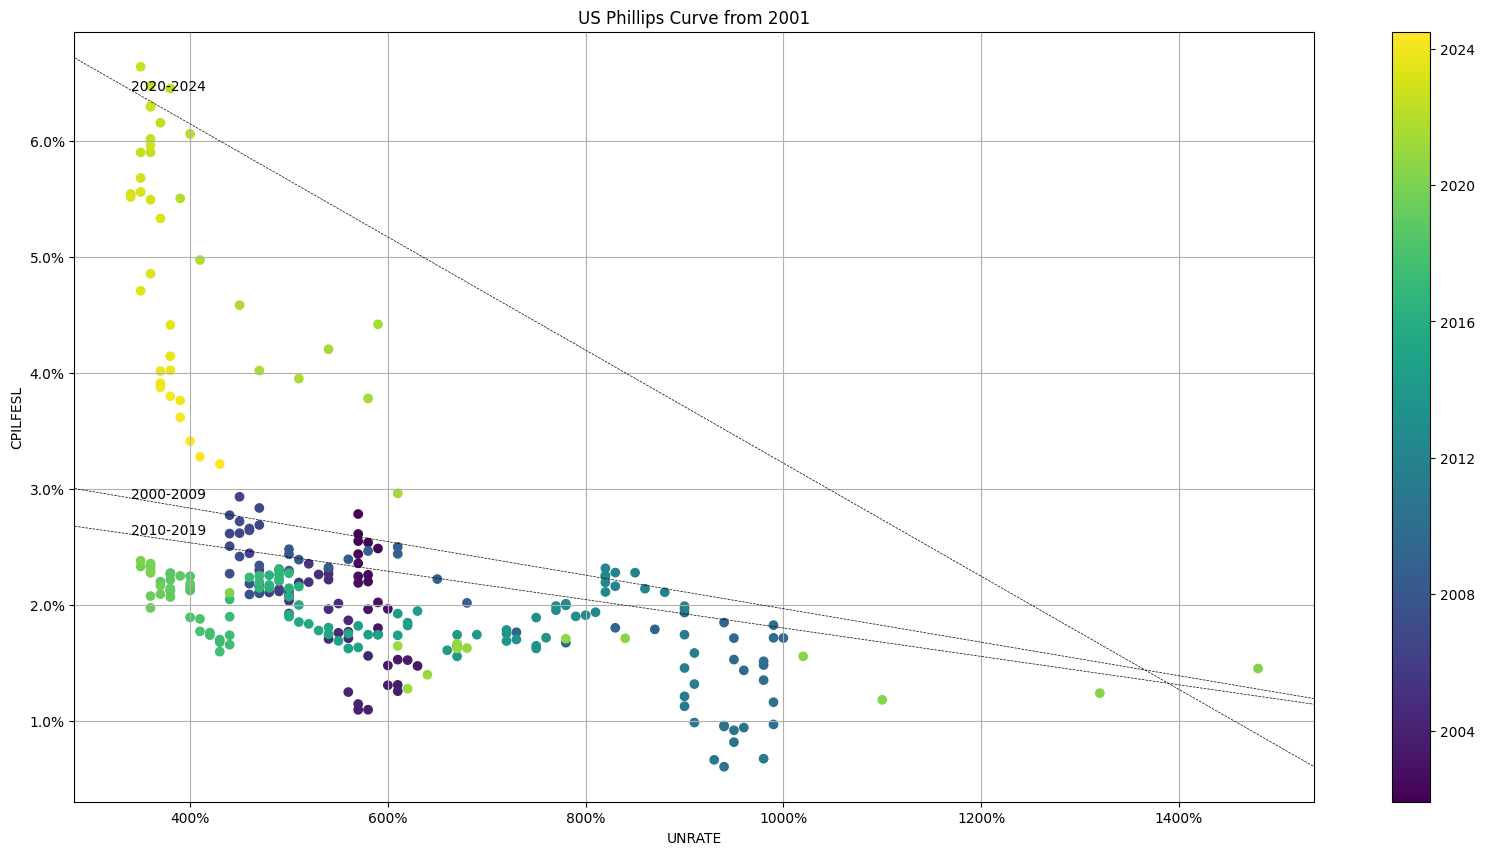

In [7]:
fig, ax = plt.subplots(figsize=(20, 10))
df = phillips_curve_df.loc[decades[0][0]:]
sc = ax.scatter(x=df.iloc[:,0], y=df.iloc[:,1],
                c=mdates.date2num(df.index))

for idx, (slope, intercept) in enumerate(slopes_and_intercepts):
    ax.axline((df.iloc[:,0].min(), intercept), slope=slope, linestyle='--', color='k', linewidth=.5)
    plt.text(df.iloc[:,0].min(), intercept, f'{decades[idx][0]:%Y}-{decades[idx][1]:%Y}')

ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_xlabel(df.columns[0])
ax.set_ylabel(df.columns[1])
ax.set_title('US Phillips Curve from {:%Y}'.format(phillips_curve_df.index[0]))
ax.grid(True)
loc = mdates.AutoDateLocator()
_ = fig.colorbar(sc, ticks=loc, format=mdates.AutoDateFormatter(loc))